In [2]:
!pip install pennylane
from IPython.display import clear_output
clear_output()

In [3]:
import pennylane as qml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from keras.datasets import cifar10, fashion_mnist, mnist
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from sklearn.preprocessing import OneHotEncoder
import math
import threading


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [4]:
from sklearn.model_selection import train_test_split

# Data for circuit (fashion mnist 16x16 images of 4 classes only):
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Filter out only the first four labels (0, 1, 2, 3)
train_filter = np.isin(y_train, [0, 1, 2, 3])
test_filter = np.isin(y_test, [0, 1, 2, 3])

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Resize the images to 16x16 pixels
x_train_resized = np.array([resize(image, (16, 16), mode='reflect', anti_aliasing=True) for image in x_train])  # resize
x_test_resized = np.array([resize(image, (16, 16), mode='reflect', anti_aliasing=True) for image in x_test])

x_train_flat = x_train_resized.reshape(-1, 16*16)
x_test_flat = x_test_resized.reshape(-1, 16*16)

# Scaling
x_train_scaled = x_train_flat / 255.0
x_test_scaled = x_test_flat / 255.0

# Split the data into training (60%) and validation (20%) sets
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train, test_size=0.25, random_state=42)

# After the split, x_train will contain 60% of the data and x_val will contain 20% (since we did a 75/25 split on the initial 80%)
x_test = np.array([arr.flatten() for arr in x_test_scaled])

# Print the sizes to confirm the split
print(f"Training set size: {x_train.shape[0]}")
print(f"Validation set size: {x_val.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set size: 18000
Validation set size: 6000
Test set size: 4000


In [5]:
# Set up the device with 8 qubits
dev = qml.device("default.qubit", wires=10)

H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])

# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 256 states (2^8 = 256)

    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

    # First Convolution

    qml.CRY(phi=phis[0], wires=[7, 6])

    qml.CRY(phi=phis[1], wires=[6, 5])

    qml.CRY(phi=phis[2], wires=[5, 4])

    qml.CRY(phi=phis[3], wires=[4, 7])

    qml.CRY(phi=phis[4], wires=[3, 2])

    qml.CRY(phi=phis[5], wires=[2, 1])

    qml.CRY(phi=phis[6], wires=[1, 0])

    qml.CRY(phi=phis[7], wires=[0, 3])

    qml.Barrier()


    # First Pooling

    qml.CRZ(phi=phis[8], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[9], wires=[7, 6])

    qml.CRZ(phi=phis[8], wires=[3, 2])
    qml.X(wires=3)
    qml.CRX(phi=phis[9], wires=[3, 2])

    qml.Barrier()

    # Activations 1
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[10], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[11], wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(phi=phis[12], wires=2)

    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[13], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[14], wires=5)
    qml.Hadamard(wires=6)
    qml.RZ(phi=phis[15], wires=6)

    qml.Barrier()

    # Second Convolution

    qml.CRY(phi=phis[16], wires=[6, 5])

    qml.CRY(phi=phis[17], wires=[5, 4])

    qml.CRY(phi=phis[18], wires=[4, 6])

    qml.CRY(phi=phis[19], wires=[2, 1])

    qml.CRY(phi=phis[20], wires=[1, 0])

    qml.CRY(phi=phis[21], wires=[0, 2])

    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[22], wires=[6, 5])
    qml.X(wires=6)
    qml.CRX(phi=phis[23], wires=[6, 5])

    qml.CRZ(phi=phis[22], wires=[2, 1])
    qml.X(wires=2)
    qml.CRX(phi=phis[23], wires=[2, 1])

    qml.Barrier()

    # Activations 2
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[24], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[25], wires=1)

    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[26], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[27], wires=5)

    qml.Barrier()

    # Third Convolution

    qml.CRY(phi=phis[28], wires=[5, 4])

    qml.CRY(phi=phis[29], wires=[4, 5])

    qml.CRY(phi=phis[30], wires=[1, 0])

    qml.CRY(phi=phis[31], wires=[0, 1])

    qml.Barrier()

    # Third Pooling

    qml.CRZ(phi=phis[32], wires=[5, 4])
    qml.X(wires=5)
    qml.CRX(phi=phis[33], wires=[5, 4])

    qml.CRZ(phi=phis[32], wires=[1, 0])
    qml.X(wires=1)
    qml.CRX(phi=phis[33], wires=[1, 0])

    # Ancilla qubits
    qml.CNOT(wires=[0, 8])
    qml.CNOT(wires=[4, 9])

    # Return the final state vector
    return qml.probs(wires=[8, 9])

results = []

for i in range(100):
    # Execute the circuit and retrieve the state vector
    phis = np.random.uniform(-1, 1, size=34)
    state_vector = quantum_circuit(x_train[i], phis)

    # Convert the state vector into probabilities by taking the absolute square of each amplitude
    probabilities = np.abs(state_vector)**2

    results.append(probabilities)

    # Print the resulting probabilities
    #print("Probabilities:", probabilities.numpy())

    # Reshape the probabilities array into a 16x16 array for the heatmap
    '''probabilities_reshaped = probabilities.reshape(2, 2)'''

    # Create a heatmap of the probabilities using seaborn
    '''plt.figure(figsize=(8, 6))
    sns.heatmap(probabilities_reshaped, annot=False, cmap="viridis")

    # Add labels and title
    plt.title("Heatmap of Probabilities for 8-Qubit Quantum Circuit")
    plt.xlabel("State Index (0-15)")
    plt.ylabel("State Index (0-15)")'''

    # Show the plot
    #plt.show()

highest = {0: 0, 1: 0, 2: 0, 3: 0}

for i in results:
    ind = 0
    m = i[0]

    if i[1] > m:
        ind = 1
        m = i[1]
    if i[2] > m:
        ind = 2
        m = i[2]
    if i[3] > m:
        ind = 3
        m = i[3]

    highest[ind] += 1

highest

<ipython-input-5-0e373ece2428>:140: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  probabilities = np.abs(state_vector)**2


{0: 21, 1: 31, 2: 18, 3: 30}

In [6]:
for i in results:
    print(i**(1/2))

tensor([0.1854, 0.2248, 0.2049, 0.3849], dtype=torch.float64)
tensor([0.0906, 0.3666, 0.1126, 0.4301], dtype=torch.float64)
tensor([0.3043, 0.1923, 0.3002, 0.2032], dtype=torch.float64)
tensor([0.2802, 0.4462, 0.0997, 0.1738], dtype=torch.float64)
tensor([0.1352, 0.1058, 0.3424, 0.4167], dtype=torch.float64)
tensor([0.2588, 0.4663, 0.0925, 0.1824], dtype=torch.float64)
tensor([0.2487, 0.1303, 0.3860, 0.2349], dtype=torch.float64)
tensor([0.1227, 0.3549, 0.1531, 0.3693], dtype=torch.float64)
tensor([0.3127, 0.2897, 0.1997, 0.1978], dtype=torch.float64)
tensor([0.3982, 0.1536, 0.2933, 0.1550], dtype=torch.float64)
tensor([0.2953, 0.2774, 0.1966, 0.2307], dtype=torch.float64)
tensor([0.3064, 0.1552, 0.3517, 0.1867], dtype=torch.float64)
tensor([0.1687, 0.1236, 0.3864, 0.3214], dtype=torch.float64)
tensor([0.1884, 0.1856, 0.2954, 0.3306], dtype=torch.float64)
tensor([0.4277, 0.1046, 0.3815, 0.0862], dtype=torch.float64)
tensor([0.2909, 0.2069, 0.3015, 0.2007], dtype=torch.float64)
tensor([

(<Figure size 3500x1100 with 1 Axes>, <Axes: >)


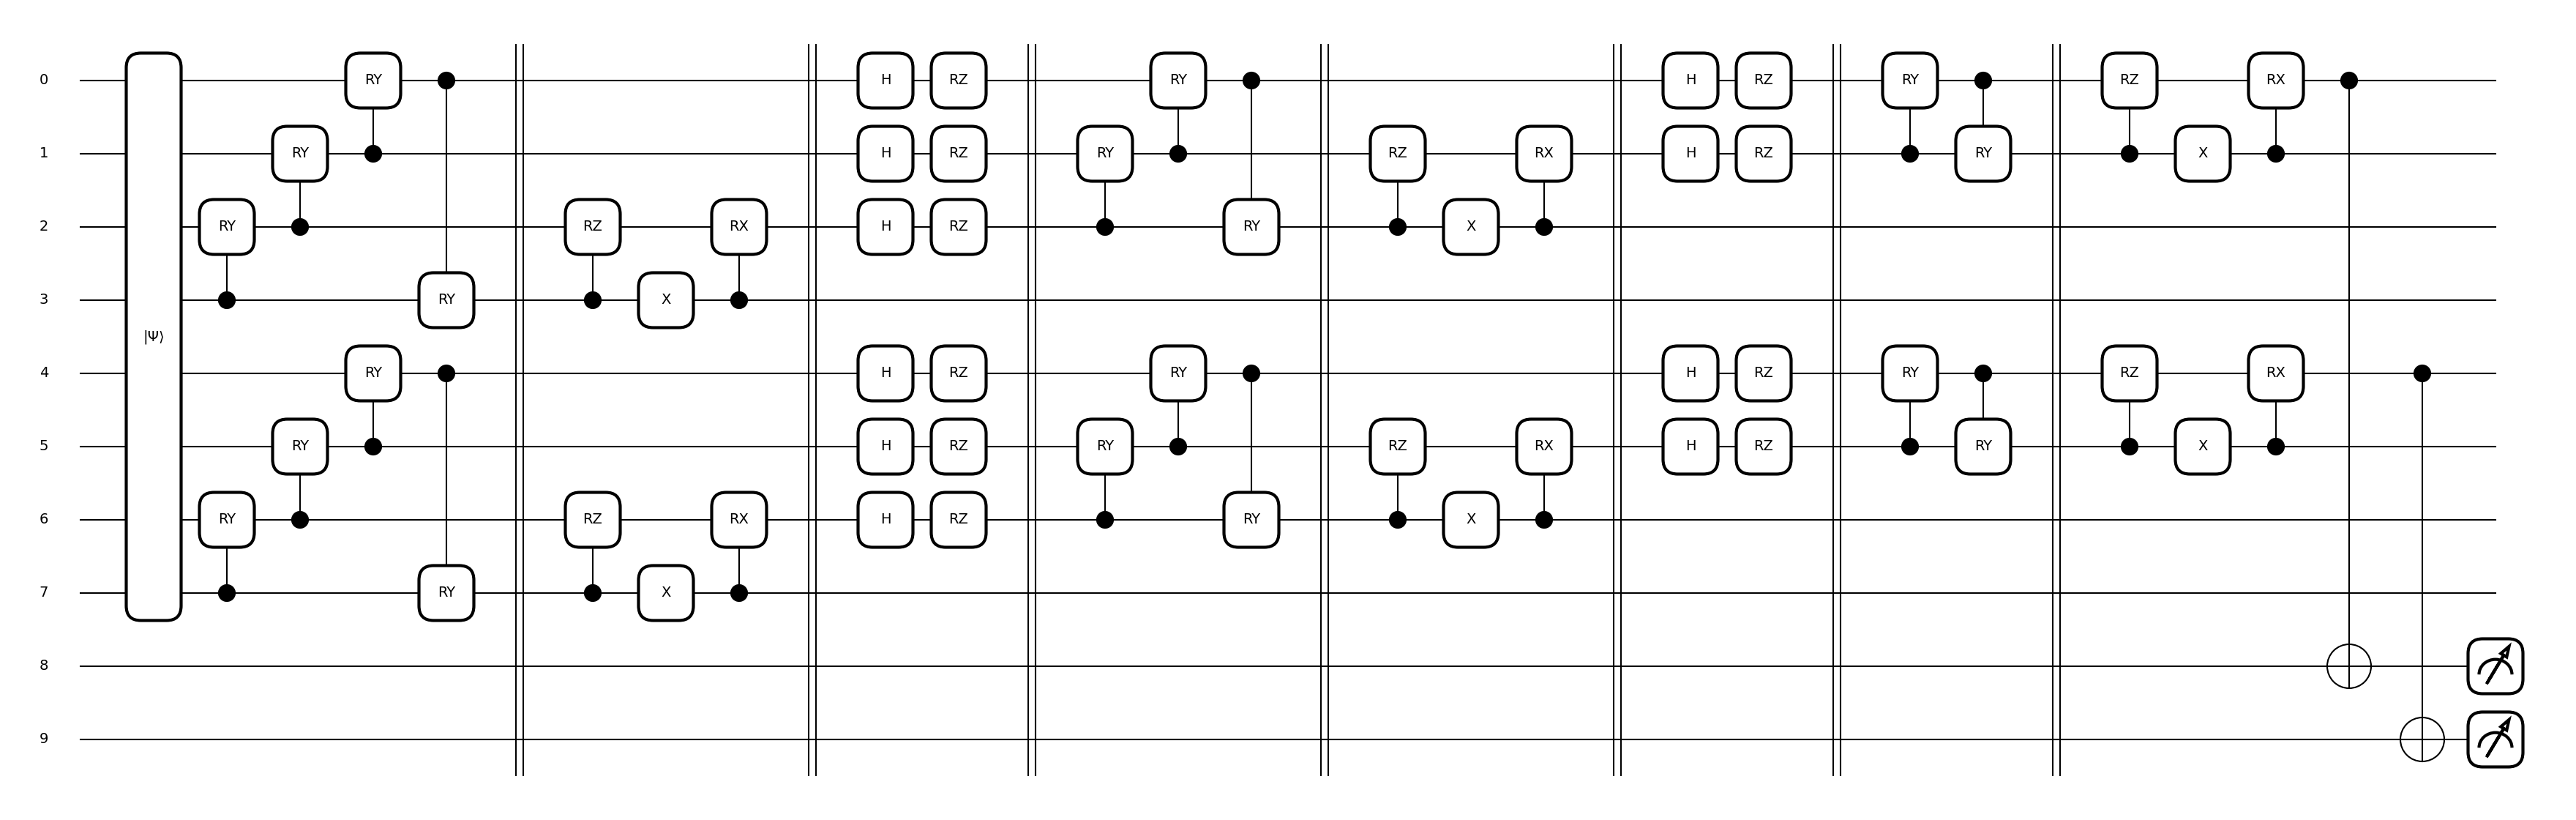

In [7]:
drawer = qml.draw_mpl(quantum_circuit)(x_train[0], phis)
print(drawer)

In [8]:
class QCNN(torch.nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        # Initialize the trainable quantum circuit parameters with uniform distribution
        torch.random.manual_seed(42)
        self.phis = torch.nn.Parameter(torch.empty(34))  # Create an uninitialized tensor of size 17
        torch.nn.init.uniform_(self.phis, a=-0.314, b=0.314)  # Initialize phis with values between -0.01 and 0.01

    def forward(self, x):
        # Call the quantum circuit and return the log-probabilities
        constrained_phis = self.phis * np.pi  # Optional: Mapping the parameters to [-pi, pi] without tanh
        return torch.log(quantum_circuit(x, constrained_phis))


In [9]:
# Set up the model, optimizer, and loss function
model = QCNN()
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()  # Use NLLLoss since output is probabilities


In [10]:
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

In [11]:
# Convert prepared data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

phi_history = []
loss_history = []
val_loss_history = []
accuracy_history = [0.0]
val_accuracy_history = [0.0]


# Early Stopping params
patience = 10
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Training loop
num_epochs = 100  # Adjust as needed
batch_size = 32

for epoch in range(num_epochs):

    if early_stop:
        print("Early stopping triggered.")
        break

    epoch_loss = 0
    model.train()

    # Keep a record of parameter (phi) values
    phi_history.append(model.phis.clone().detach().numpy())

    # Shuffle the training data at the start of each epoch
    torch.manual_seed(seed + epoch)
    permutation = torch.randperm(x_train_tensor.size()[0])
    x_train_tensor = x_train_tensor[permutation]
    y_train_tensor = y_train_tensor[permutation]

    # Iterate over batches
    for i in range(0, len(x_train_tensor), batch_size):
        x_batch = x_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()

        # Forward pass: compute predictions
        outputs = model(x_batch)

        # Compute cross-entropy loss
        loss = loss_fn(outputs, y_batch)

        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Compute accuracy on the training set
    model.eval()
    with torch.no_grad():
        train_outputs = model(x_train_tensor)
        train_accuracy = compute_accuracy(train_outputs, y_train_tensor)
        accuracy_history.append(train_accuracy)
        loss_history.append(loss)

    #print(f"Training Accuracy: {train_accuracy:.4f}")

    # Validation loss (on test data)
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val_tensor)
        val_loss = loss_fn(val_outputs, y_val_tensor).item()
        val_accuracy = compute_accuracy(val_outputs, y_val_tensor)
        val_accuracy_history.append(val_accuracy)
        val_loss_history.append(val_loss)

    # Print epoch metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / (len(x_train_tensor) / batch_size):.4f}, Accuracy: {train_accuracy:.4f}  -  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

    if epochs_no_improve > 0:
        print(f"Epochs without improvement: {epochs_no_improve}")
    else:
        print("\n")


Epoch 1/100, Loss: 1.0890, Accuracy: 0.7969  -  Validation Loss: 0.9947, Validation Accuracy: 0.7963


Epoch 2/100, Loss: 0.9734, Accuracy: 0.8069  -  Validation Loss: 0.9555, Validation Accuracy: 0.8095


Epoch 3/100, Loss: 0.9541, Accuracy: 0.8083  -  Validation Loss: 0.9493, Validation Accuracy: 0.8140


Epoch 4/100, Loss: 0.9504, Accuracy: 0.8141  -  Validation Loss: 0.9479, Validation Accuracy: 0.8143


Epoch 5/100, Loss: 0.9494, Accuracy: 0.8127  -  Validation Loss: 0.9472, Validation Accuracy: 0.8157


Epoch 6/100, Loss: 0.9489, Accuracy: 0.8159  -  Validation Loss: 0.9468, Validation Accuracy: 0.8178


Epoch 7/100, Loss: 0.9486, Accuracy: 0.8156  -  Validation Loss: 0.9467, Validation Accuracy: 0.8225


Epoch 8/100, Loss: 0.9485, Accuracy: 0.8155  -  Validation Loss: 0.9463, Validation Accuracy: 0.8178


Epoch 9/100, Loss: 0.9482, Accuracy: 0.8123  -  Validation Loss: 0.9465, Validation Accuracy: 0.8143
Epochs without improvement: 1
Epoch 10/100, Loss: 0.9479, Accuracy: 0.8186 

In [12]:
from collections import defaultdict

# Initialize a dictionary to store counts per class
class_correct = defaultdict(int)
class_total = defaultdict(int)

test_outs = None
model.eval()

# List of class labels
class_labels = [0, 1, 2, 3]

with torch.no_grad():
    test_outputs = model(x_test_tensor)
    test_outs = test_outputs
    _, predicted = torch.max(test_outputs, 1)

    # Calculate overall accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Overall Test Accuracy: {accuracy:.4f}")

    # Calculate accuracy per class
    for i in range(len(y_test_tensor)):
        label = y_test_tensor[i].item()
        pred = predicted[i].item()

        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

# Print accuracy for each class
for label in class_labels:
    if class_total[label] > 0:
        class_accuracy = class_correct[label] / class_total[label]
        print(f"Accuracy for class {label}: {class_accuracy:.4f}")
    else:
        print(f"No samples found for class {label}.")


Overall Test Accuracy: 0.8073
Accuracy for class 0: 0.6510
Accuracy for class 1: 0.8830
Accuracy for class 2: 0.9420
Accuracy for class 3: 0.7530


In [13]:
# Evaluation on the test set
test_outs = None
model.eval()
with torch.no_grad():
    test_outputs = model(x_test_tensor)
    test_outs = test_outputs
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy:.4f}")



Test Accuracy: 0.8073


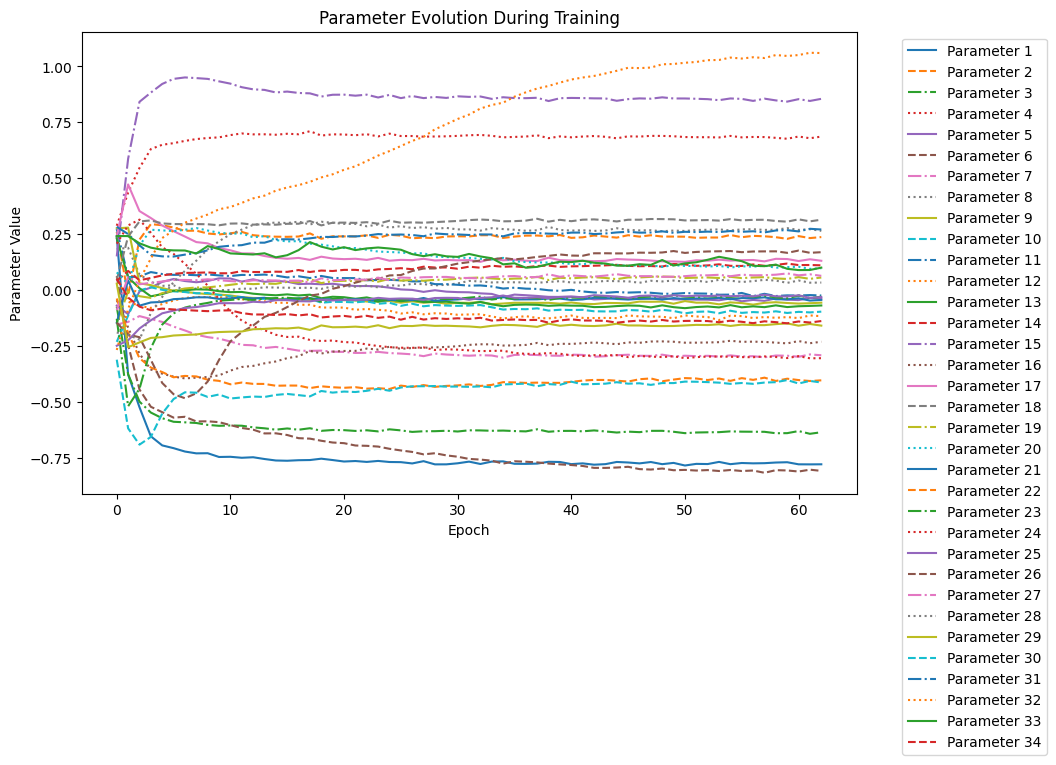

In [14]:
# Plot parameter history
parameter_history = np.array(phi_history)  # Convert to NumPy array for easier manipulation

# Defined line styes
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(10, 6))
for i in range(len(model.phis)):  # 17 parameters
    plt.plot(parameter_history[:, i], label=f'Parameter {i+1}', linestyle=line_styles[i % len(line_styles)])

plt.title("Parameter Evolution During Training")
plt.xlabel("Epoch")
plt.ylabel("Parameter Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
plt.show()


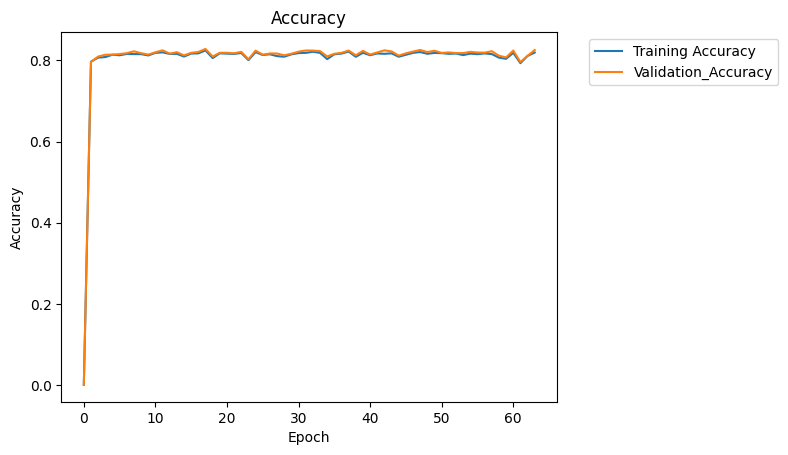

In [15]:
plt.plot(accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation_Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the loss function over a range of values for each parameter
def plot_loss_over_params(model, x_train_tensor, y_train_tensor, param_index, param_range=np.linspace(-4, 4, 100)):
    # Clone the model parameters so we can manipulate them
    original_phis = model.phis.clone().detach()

    # Store the losses
    losses = []

    # Vary the selected parameter within the given range
    for param_value in param_range:
        # Set the selected parameter to the new value
        model.phis = torch.nn.Parameter(original_phis.clone())
        model.phis.data[param_index] = param_value  # Modify only the parameter at index `param_index`

        # Compute the loss
        model.eval()
        with torch.no_grad():
            outputs = model(x_train_tensor)
            loss = loss_fn(outputs, y_train_tensor).item()

        # Store the loss value
        losses.append(loss)

    # Plot the loss function for the selected parameter
    plt.plot(param_range, losses)
    plt.title(f"Loss Function vs Parameter {param_index + 1}")
    plt.xlabel(f"Parameter {param_index + 1}")
    plt.ylabel("Loss")
    plt.show()

# Example: plot the loss for the first parameter (index 0)
plot_loss_over_params(model, x_train_tensor, y_train_tensor, param_index=0)

# You can repeat this for other parameters (e.g., index 1, 2, etc.)
for i in range(16):
    plot_loss_over_params(model, x_train_tensor, y_train_tensor, param_index=i)

KeyboardInterrupt: 

In [17]:
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_val, return_counts=True)
print(f"Validation class distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test class distribution: {dict(zip(unique, counts))}")


Training class distribution: {np.uint8(0): np.int64(4488), np.uint8(1): np.int64(4459), np.uint8(2): np.int64(4532), np.uint8(3): np.int64(4521)}
Validation class distribution: {np.uint8(0): np.int64(1512), np.uint8(1): np.int64(1541), np.uint8(2): np.int64(1468), np.uint8(3): np.int64(1479)}
Test class distribution: {np.uint8(0): np.int64(1000), np.uint8(1): np.int64(1000), np.uint8(2): np.int64(1000), np.uint8(3): np.int64(1000)}
